# This part 3 of 3 is TBD very soon <a class='tocSkip'>

**Previous notebooks:** <br>
[Part 1: Data mining and munging](tdp_1_3_data_mining_and_cleaning.ipynb)<br>
[Part 2: Data stats and visuals](tdp_2_3_data_statistics_visualization.ipynb)

In [1]:
# !pip install watermark
# %load_ext watermark
%reload_ext watermark
%watermark -a "Norbert Oksza Strzelecki" -v -p numpy,pandas,matplotlib,seaborn,sklearn

Norbert Oksza Strzelecki 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.2
pandas 0.23.4
matplotlib 3.0.0
seaborn 0.9.0
sklearn 0.20.0


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
import time

### Data loading <a class='tocSkip'>

In [2]:
# Main data for modeling
biker_class = pd.read_csv('processed/clean_biker_class.csv', index_col=0)

# # Additional parts for statistics
# biker_stats = pd.read_csv('preprocessed/pre_biker_stats.csv', index_col=0)
# biker_by_stage = pd.read_csv('preprocessed/pre_biker_by_stage.csv', index_col=0)
# stage_results = pd.read_csv('preprocessed/pre_stages.csv', index_col=False)
# stage_class = pd.read_csv('preprocessed/pre_stages_summary.csv', index_col=False)

In [3]:
# Fixing 'date' type column
biker_class['date'] = pd.to_datetime(biker_class['date'])

In [4]:
# Sorting by 'date' column to avoid data leakage later during splitting to train/test batches
biker_class.sort_values('date', ascending=True, inplace=True)
biker_class.reset_index(drop=True, inplace=True)

# Preparing data

In [5]:
# Baseline prediction for 0s
1 - biker_class.y_label.mean()

0.9352997145575642

In [6]:
# Poping out label column
y = biker_class.pop('y_label')

-------

In [7]:
biker_class.columns

Index(['name', 'nation', 'age', 'team', 'year', 'stage', 'position',
       'time_in_s', 'gc', 'gc_time_in_s', 'mount_jerseys', 'point_jerseys',
       'sprint_jerseys', 'youth_jerseys', 'followers', 'total_wins', 'n_tours',
       'n_stages', 'avg_year', 'best_pos_ovr', 'avg_pos_ovr', 'worst_pos_ovr',
       'best_time_ovr', 'avg_time_ovr', 'worst_time_ovr', 'best_gc_ovr',
       'avg_gc_ovr', 'worst_gc_ovr', 'best_gc_time_ovr', 'avg_gc_time_ovr',
       'worst_gc_time_ovr', 'n_top10_ovr', 'n_win_ovr', 'best_pos_ovr_l3',
       'avg_pos_ovr_l3', 'worst_pos_ovr_l3', 'best_time_ovr_l3',
       'avg_time_ovr_l3', 'worst_time_ovr_l3', 'best_gc_ovr_l3',
       'avg_gc_ovr_l3', 'worst_gc_ovr_l3', 'best_gc_time_ovr_l3',
       'avg_gc_time_ovr_l3', 'worst_gc_time_ovr_l3', 'n_top10_l3', 'n_win_l3',
       'perc_top10_ovr', 'perc_win_ovr', '2015_div', '2015_fc_rank',
       '2015_race_days', '2015_team', '2015_wins', '2015_year_km', '2016_div',
       '2016_fc_rank', '2016_race_days', '2016_te

In [8]:
print(biker_class.shape)
biker_class.head()

(5255, 83)


,name,nation,age,team,year,stage,position,time_in_s,gc,gc_time_in_s,...,date,stage_type_code,dist,finish,temp,rel_humid,wind_dir,wind_speed,clouds_ovrl,visibility
0,Y.Hutarovich,Belarus,31,AG2R La Mondiale,2014,1,1,20870.0,1,20860.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
1,T.De Gendt,Belgium,28,Omega Pharma-Quick Step,2014,1,108,20992.0,109,20992.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
2,M.Belkov,Russia,29,Team Katusha,2014,1,109,21000.0,110,21000.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
3,B.Lancaster,Spain,35,Orica - GreenEDGE,2014,1,110,21022.0,111,21022.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9
4,S.Bewley,New Zealand,27,Orica - GreenEDGE,2014,1,111,21022.0,112,21022.0,...,2014-08-03,1,226.0,Bygdoszcz,31.5,38,ESE,2,6,9


## Remapping & Dropping

In [9]:
# Due to too many levels, trying with the '_team' data removed
# Try: change team levels for only 5 top + 1 as a rest
biker_class.drop('team', axis=1, inplace=True)
biker_class.drop(biker_class.loc[:,'2015_team':'2018_team':6], axis=1, inplace=True)

In [10]:
biker_class.loc[:,'2015_div':'2018_div':5].head()

,2015_div,2016_div,2017_div,2018_div
0,PROF,PROF,NONE,NONE
1,PRT,PRT,PRT,PRT
2,PRT,PRT,PRT,PRT
3,PRT,PRT,PRT,PROF
4,PRT,PRT,PRT,PRT


In [11]:
# Remapping '_div' team types with numbers as they show a true level of professionalism
biker_class.loc[:,'2015_div':'2018_div':5] = biker_class.loc[:,'2015_div':'2018_div':5]\
                                                        .replace({'PRT':1, 'PROF':2, 'CONT':3, 'NONE':4})

In [12]:
biker_class.loc[:,'2015_div':'2018_div':5].head()

,2015_div,2016_div,2017_div,2018_div
0,2,2,4,4
1,1,1,1,1
2,1,1,1,1
3,1,1,1,2
4,1,1,1,1


## Information about features

### Datetime feature (1)

In [13]:
biker_class.select_dtypes('datetime').head()

,date
0,2014-08-03
1,2014-08-03
2,2014-08-03
3,2014-08-03
4,2014-08-03


### Categorical features (4)

In [14]:
biker_class.select_dtypes('object').columns

Index(['name', 'nation', 'finish', 'wind_dir'], dtype='object')

In [15]:
print(biker_class.select_dtypes('object').shape)
biker_class.select_dtypes('object').head(3)

(5255, 4)


,name,nation,finish,wind_dir
0,Y.Hutarovich,Belarus,Bygdoszcz,ESE
1,T.De Gendt,Belgium,Bygdoszcz,ESE
2,M.Belkov,Russia,Bygdoszcz,ESE


### Numeric features (73)

In [16]:
biker_class.select_dtypes('number').columns

Index(['age', 'year', 'stage', 'position', 'time_in_s', 'gc', 'gc_time_in_s',
       'mount_jerseys', 'point_jerseys', 'sprint_jerseys', 'youth_jerseys',
       'followers', 'total_wins', 'n_tours', 'n_stages', 'avg_year',
       'best_pos_ovr', 'avg_pos_ovr', 'worst_pos_ovr', 'best_time_ovr',
       'avg_time_ovr', 'worst_time_ovr', 'best_gc_ovr', 'avg_gc_ovr',
       'worst_gc_ovr', 'best_gc_time_ovr', 'avg_gc_time_ovr',
       'worst_gc_time_ovr', 'n_top10_ovr', 'n_win_ovr', 'best_pos_ovr_l3',
       'avg_pos_ovr_l3', 'worst_pos_ovr_l3', 'best_time_ovr_l3',
       'avg_time_ovr_l3', 'worst_time_ovr_l3', 'best_gc_ovr_l3',
       'avg_gc_ovr_l3', 'worst_gc_ovr_l3', 'best_gc_time_ovr_l3',
       'avg_gc_time_ovr_l3', 'worst_gc_time_ovr_l3', 'n_top10_l3', 'n_win_l3',
       'perc_top10_ovr', 'perc_win_ovr', '2015_div', '2015_fc_rank',
       '2015_race_days', '2015_wins', '2015_year_km', '2016_div',
       '2016_fc_rank', '2016_race_days', '2016_wins', '2016_year_km',
       '2017_div',

In [17]:
print(biker_class.select_dtypes('number').shape)
biker_class.select_dtypes('number').head()

(5255, 73)


,age,year,stage,position,time_in_s,gc,gc_time_in_s,mount_jerseys,point_jerseys,sprint_jerseys,...,2018_race_days,2018_wins,2018_year_km,stage_type_code,dist,temp,rel_humid,wind_speed,clouds_ovrl,visibility
0,31,2014,1,1,20870.0,1,20860.0,0,6,0,...,0.0,0.0,0.0,1,226.0,31.5,38,2,6,9
1,28,2014,1,108,20992.0,109,20992.0,11,1,4,...,82.0,2.0,12061.0,1,226.0,31.5,38,2,6,9
2,29,2014,1,109,21000.0,110,21000.0,2,0,2,...,48.0,0.0,7465.0,1,226.0,31.5,38,2,6,9
3,35,2014,1,110,21022.0,111,21022.0,0,1,0,...,37.0,1.0,5948.6,1,226.0,31.5,38,2,6,9
4,27,2014,1,111,21022.0,112,21022.0,0,0,0,...,42.0,0.0,6257.2,1,226.0,31.5,38,2,6,9


## Transforming features into dummy categories & scaling values

In [18]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [19]:
'''
To prevent data leakage observations need to be splitted depending on timepoint in the 'date' column 
(not using random splitting in 'train_test_split'), because going down the dataframe it is 'sequencial' data,
year by year, stage by stage
'''

# Based on 'date' column setting cutoff point to avoid data leakage 
cutoff = 3120

# Selecting numerical and categorical features
data_numerics = biker_class.select_dtypes(include = ['number'])
# Skipping 'name' column
data_categorical = biker_class.select_dtypes(exclude = ['number']).iloc[:,1:]

# Converting categorical features into dummies
categorical_dummies = pd.get_dummies(data_categorical)
categorical_dummies_train = categorical_dummies.iloc[:cutoff,:]
categorical_dummies_test = categorical_dummies.iloc[cutoff:,:]

# Splitting numerical features into two separate dataframes for further scaling
data_numerics_train = data_numerics.iloc[:cutoff,:]
data_numerics_test = data_numerics.iloc[cutoff:,:]

# Setting scaler
numeric_scaler = StandardScaler()

# Scaling 'train' part (fit_transform)
numerics_scaled_train = numeric_scaler.fit_transform(data_numerics_train)
numerics_scaled_train = pd.DataFrame(numerics_scaled_train, columns=data_numerics.columns, index=data_numerics_train.index)

# Scaling 'test' part (transform)
numerics_scaled_test = numeric_scaler.transform(data_numerics_test)
numerics_scaled_test = pd.DataFrame(numerics_scaled_test, columns=data_numerics.columns, index=data_numerics_test.index)

# Defining final dataframes
X_train = pd.concat([biker_class.name.iloc[:cutoff], categorical_dummies_train, numerics_scaled_train], axis=1)
X_test = pd.concat([biker_class.name.iloc[cutoff:], categorical_dummies_test, numerics_scaled_test], axis=1)

y_train = y[:cutoff]
y_test = y[cutoff:] 

C:\Users\cyberdeck\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cyberdeck\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cyberdeck\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [20]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3120, 147) (2135, 147)
(3120,) (2135,)


## Modeling

In [21]:
import warnings
from numpy import mean
from numpy import std

from scipy.stats.distributions import uniform, randint

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [22]:
print('Train batch ------------')
print(y_train.value_counts(normalize=True))
print()
print('Test batch -------------')
print(y_test.value_counts(normalize=True))

Train batch ------------
0    0.9375
1    0.0625
Name: y_label, dtype: float64

Test batch -------------
0    0.932084
1    0.067916
Name: y_label, dtype: float64


### Baseline

In [23]:
# Helper functions to quickly assess a range of interest for different algorithms

# Create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # linear models
    models['logreg   '] = LogisticRegression(class_weight='balanced')
    alpha = [0.1, 0.2]
    for a in alpha:
        models['ridge_'+str(a)] = RidgeClassifier(alpha=a, class_weight='balanced')
    models['sgd      '] = SGDClassifier(max_iter=1000, tol=1e-3, class_weight='balanced')
    models['pas_agr  '] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, class_weight='balanced')
    models['svm_lin  '] = SVC(kernel='linear', class_weight='balanced')
    models['svm_poly '] = SVC(kernel='poly', class_weight='balanced')
    c_values = [0.8, 0.9, 1.0, 2.0, 3.0]
    for c in c_values:
        models['svm_r_'+str(c)] = SVC(C=c, class_weight='balanced')
    models['bayes    '] = GaussianNB()
    # ensemble model
    models['rf       '] = RandomForestClassifier(n_estimators=100)
    print('Defined %d models' % len(models))
    return models
 
# Create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = []
    # standardization
#     steps.append(('standardize', StandardScaler()))
    # normalization
#     steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
# Evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores
 
# Evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores
 
# Evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='balanced_accuracy'):
    results = {}
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = mean(scores), std(scores)
            print('> %s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('> %s: error' % name)
    return results
 
# Print and plot the top n results
def summarize_results(results, maximize=True, top_n=15):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank = %d, Name = %s, Score = %.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)

In [24]:
# Helper function plotting Precision-Recall Curve instead of a ROC Curve due to class imbalance

def precission_recall_plot(classifier, X_test):
    # predict probabilities
    probas = classifier.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probas = probas[:, 1]
    # predict class values
    y_pred = classifier.predict(X_test)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probas)
    # calculate F1 score
    f1 = f1_score(y_test, y_pred)
    # calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_test, probas, average='weighted')
    print('Scores: f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))
    plt.figure(figsize=(5,5))
    # plot no skill model
    plt.plot([0, 1], [0.5, 0.5], linestyle='--', linewidth=1)
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.', markersize=4, color='orangered', linewidth=1)
    # show the plot
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.title('2-class Precision-Recall curve: AP={0:0.3f}'.format(ap))
    plt.show()
    
def balanced_accuracy_value(classifier):
    return balanced_accuracy_score(y_test, classifier.predict(X_test_cut))

In [25]:
# Skipping 'name' and 'date' columns
X_train_cut = X_train.iloc[:,2:]
X_test_cut = X_test.iloc[:,2:]

In [26]:
# Get model list
models = define_models()

# Evaluate models
results = evaluate_models(X_train_cut, y_train, models)

Defined 14 models
> logreg   : 0.923 (+/-0.043)
> ridge_0.1: 0.880 (+/-0.067)
> ridge_0.2: 0.883 (+/-0.065)
> sgd      : 0.854 (+/-0.069)
> pas_agr  : 0.876 (+/-0.056)
> svm_lin  : 0.905 (+/-0.071)
> svm_poly : 0.717 (+/-0.070)
> svm_r_0.8: 0.788 (+/-0.059)
> svm_r_0.9: 0.790 (+/-0.059)
> svm_r_1.0: 0.790 (+/-0.061)
> svm_r_2.0: 0.788 (+/-0.076)
> svm_r_3.0: 0.784 (+/-0.082)
> bayes    : 0.788 (+/-0.096)
> rf       : 0.972 (+/-0.031)



Rank = 1, Name = rf       , Score = 0.972 (+/- 0.031)
Rank = 2, Name = logreg   , Score = 0.923 (+/- 0.043)
Rank = 3, Name = svm_lin  , Score = 0.905 (+/- 0.071)
Rank = 4, Name = ridge_0.2, Score = 0.883 (+/- 0.065)
Rank = 5, Name = ridge_0.1, Score = 0.880 (+/- 0.067)
Rank = 6, Name = pas_agr  , Score = 0.876 (+/- 0.056)
Rank = 7, Name = sgd      , Score = 0.854 (+/- 0.069)
Rank = 8, Name = svm_r_0.9, Score = 0.790 (+/- 0.059)
Rank = 9, Name = svm_r_1.0, Score = 0.790 (+/- 0.061)
Rank = 10, Name = bayes    , Score = 0.788 (+/- 0.096)
Rank = 11, Name = svm_r_2.0, Score = 0.788 (+/- 0.076)
Rank = 12, Name = svm_r_0.8, Score = 0.788 (+/- 0.059)
Rank = 13, Name = svm_r_3.0, Score = 0.784 (+/- 0.082)
Rank = 14, Name = svm_poly , Score = 0.717 (+/- 0.070)


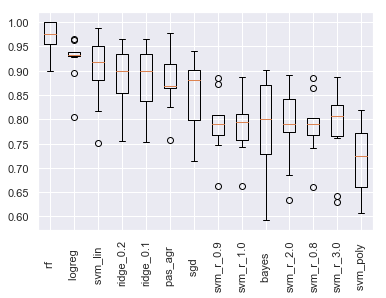

In [27]:
# Summarize results
summarize_results(results)

**Random Forrest**

In [28]:
base_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42,
                                 max_depth=200, min_samples_leaf=20, n_jobs=-1)
base_rf.fit(X_train_cut, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=200, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

Accuracy: 0.9900190608213482

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1990
           1       0.85      0.99      0.91       145

   micro avg       0.99      0.99      0.99      2135
   macro avg       0.92      0.99      0.95      2135
weighted avg       0.99      0.99      0.99      2135

Scores: f1=0.914 auc=0.996 ap=0.996


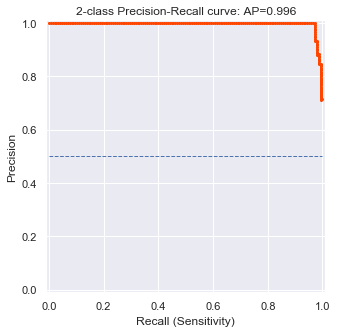

In [29]:
print('Accuracy: %s' % balanced_accuracy_value(base_rf))
print()
print(classification_report(y_test, base_rf.predict(X_test_cut)))
precission_recall_plot(base_rf, X_test_cut)

**Logistic Regression**

In [30]:
base_lr = LogisticRegression(solver='liblinear', random_state=42)
base_lr.fit(X_train_cut, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy: 0.7794229769537342

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1990
           1       0.75      0.57      0.65       145

   micro avg       0.96      0.96      0.96      2135
   macro avg       0.86      0.78      0.81      2135
weighted avg       0.95      0.96      0.96      2135

Scores: f1=0.651 auc=0.751 ap=0.752


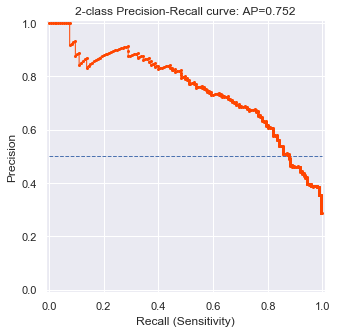

In [31]:
print('Accuracy: %s' % balanced_accuracy_value(base_lr))
print()
print(classification_report(y_test, base_lr.predict(X_test_cut)))
precission_recall_plot(base_lr, X_test_cut)

**Support Vector Machines**

In [32]:
base_svc = SVC(probability=True, gamma='auto', kernel='linear')
base_svc.fit(X_train_cut, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy: 0.8517674579795529

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.72      0.72      0.72       145

   micro avg       0.96      0.96      0.96      2135
   macro avg       0.85      0.85      0.85      2135
weighted avg       0.96      0.96      0.96      2135

Scores: f1=0.722 auc=0.803 ap=0.804


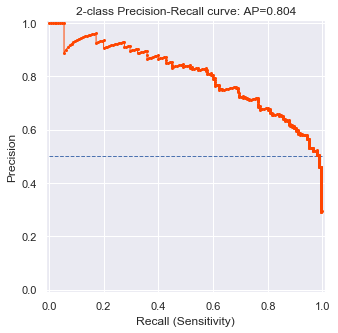

In [33]:
print('Accuracy: %s' % balanced_accuracy_value(base_svc))
print()
print(classification_report(y_test, base_svc.predict(X_test_cut)))
precission_recall_plot(base_svc, X_test_cut)

### Cross-validation with StratifiedKFold

**Logistic Regression**

In [34]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
scores_lr = cross_val_score(X=X_train_cut,
                            y=y_train,
                            estimator=lr,
                            cv=StratifiedKFold(10, shuffle=True),
                            scoring='balanced_accuracy',
                            n_jobs=-1)
lr.fit(X_train_cut, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 0.9403724553447296

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1849
           1       0.94      0.48      0.63       286

   micro avg       0.93      0.93      0.93      2135
   macro avg       0.93      0.74      0.79      2135
weighted avg       0.93      0.93      0.91      2135

Scores: f1=0.631 auc=0.783 ap=0.784


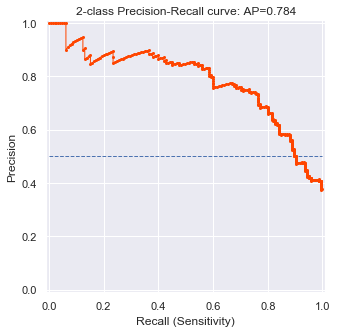

In [35]:
print('Accuracy: %s' % scores_lr.mean())
print()
print(classification_report(lr.predict(X_test_cut), y_test))
precission_recall_plot(lr, X_test_cut)

**Support Vector Machines**

In [36]:
svc = SVC(class_weight='balanced', probability=True, random_state=42, gamma='auto', kernel='linear')
scores_svc = cross_val_score(X=X_train_cut,
                             y=y_train,
                             estimator=svc,
                             cv=StratifiedKFold(10, shuffle=True),
                             scoring='balanced_accuracy',
                             n_jobs=-1)
svc.fit(X_train_cut, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Accuracy: 0.9466895182225986

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1925
           1       0.92      0.64      0.75       210

   micro avg       0.96      0.96      0.96      2135
   macro avg       0.94      0.82      0.87      2135
weighted avg       0.96      0.96      0.96      2135

Scores: f1=0.755 auc=0.853 ap=0.854


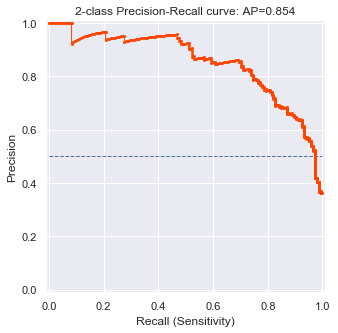

In [37]:
print('Accuracy: %s' % scores_svc.mean())
print()
print(classification_report(svc.predict(X_test_cut), y_test))
precission_recall_plot(svc, X_test_cut)

### Parameter estimation using grid search with RandomizedSearchCV

**Logistic Regression**

In [38]:
start_time = time.clock()
param_grid_lr = {'penalty':['l1','l2'],
                 'C':uniform(0.25,10.0-0.25)}

grid_lr = RandomizedSearchCV(n_iter=40, 
                             estimator=lr, 
                             cv=StratifiedKFold(10, shuffle=True), 
                             param_distributions=param_grid_lr,
                             scoring='balanced_accuracy',
                             n_jobs=-1)

print(grid_lr.fit(X_train_cut, y_train))

print('-'*50)
print('Computed in: {} minutes'.format((time.clock()-start_time)/60))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=40, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F1DE177F0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)
--------------------------------------------------
Computed in: 6.913994667762872 minutes


In [39]:
grid_lr.best_params_

{'C': 3.4904578463310583, 'penalty': 'l1'}

In [40]:
grid_lr.best_estimator_

LogisticRegression(C=3.4904578463310583, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 0.9933346287811491

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1962
           1       0.98      0.82      0.89       173

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.98      0.91      0.94      2135
weighted avg       0.98      0.98      0.98      2135

Scores: f1=0.893 auc=0.979 ap=0.979


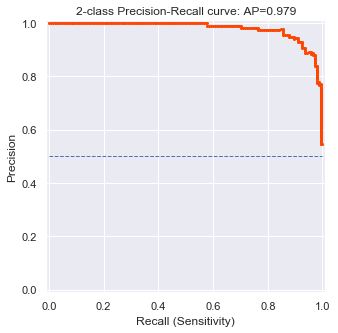

In [41]:
print('Accuracy: %s' % grid_lr.best_score_)
print()
print(classification_report(grid_lr.best_estimator_.predict(X_test_cut), y_test))
precission_recall_plot(grid_lr.best_estimator_, X_test_cut)

**Support Vector Machines**

In [42]:
start_time = time.clock()

param_grid_svc = {'kernel':['linear'],
                  'gamma':uniform(0.0,0.5),
                  'C':uniform(0.25,10.0-0.25)}
#               ,
#               {'kernel':['poly'],
#                'degree':randint(1,7),
#                'C':uniform(0.25,10.0-0.25)}
#               ,
#               {'kernel':['sigmoid'],
#                'C':uniform(0.25,10.0-0.25)}]

grid_svc = RandomizedSearchCV(n_iter=30, 
                              estimator=svc, 
                              cv=StratifiedKFold(10, shuffle=True), 
                              param_distributions=param_grid_svc,
                              scoring='balanced_accuracy',
                              n_jobs=-1)

print(grid_svc.fit(X_train_cut, y_train))

print('-'*50)
print('Computed in: {} minutes'.format((time.clock()-start_time)/60))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'kernel': ['linear'], 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F1DE5B3C8>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F1DF55588>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)
--------------------------------------------------
Computed in: 9.597111522552536 minutes


In [43]:
grid_svc.best_params_

{'C': 1.0667075054858, 'gamma': 0.19363845882755204, 'kernel': 'linear'}

In [44]:
grid_svc.best_estimator_

SVC(C=1.0667075054858, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.19363845882755204,
  kernel='linear', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

Accuracy: 0.9334272342139052

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1925
           1       0.91      0.63      0.74       210

   micro avg       0.96      0.96      0.96      2135
   macro avg       0.94      0.81      0.86      2135
weighted avg       0.96      0.96      0.95      2135

Scores: f1=0.744 auc=0.854 ap=0.855


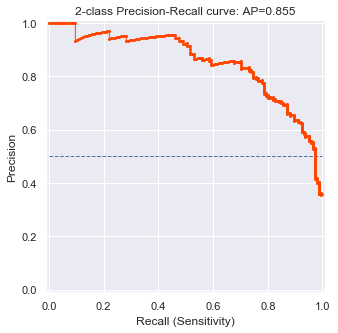

In [45]:
print('Accuracy: %s' % grid_svc.best_score_)
print()
print(classification_report(grid_svc.best_estimator_.predict(X_test_cut), y_test))
precission_recall_plot(grid_svc.best_estimator_, X_test_cut)

### Feature selection for Logistic Regression

First feature selection was carried out above using L1 regularization with the Logistic Regression

In [46]:
# Merging tables for feature selection methods
print('Before merging', X_train_cut.shape, X_test_cut.shape)
data_adult_cut = pd.concat([X_train_cut, X_test_cut], axis=0)
print('After merging ', data_adult_cut.shape)

Before merging (3120, 145) (2135, 145)
After merging  (5255, 145)


#### Statistical tests

In [47]:
from sklearn.feature_selection import SelectKBest, f_classif

In [48]:
data_adult_kbest = SelectKBest(f_classif, k=80).fit_transform(data_adult_cut, y)

X_train_kbest = data_adult_kbest[:cutoff]
X_test_kbest = data_adult_kbest[cutoff:]

scores_kbest = cross_val_score(X=X_train_kbest,
                               y=y_train,
                               estimator=grid_lr.best_estimator_,
                               cv=StratifiedKFold(10, shuffle=True),
                               scoring='balanced_accuracy',
                               n_jobs=-1)
grid_lr.best_estimator_.fit(X_train_kbest, y_train)

LogisticRegression(C=3.4904578463310583, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [49]:
# Befor e and after feature selection
X_train_cut.shape, X_train_kbest.shape

((3120, 145), (3120, 80))

Accuracy: 0.9915167843283932

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1959
           1       0.99      0.81      0.89       176

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.98      0.91      0.94      2135
weighted avg       0.98      0.98      0.98      2135

Scores: f1=0.891 auc=0.984 ap=0.984


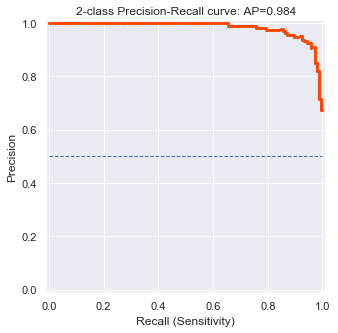

In [50]:
print('Accuracy: %s' % scores_kbest.mean())
print()
print(classification_report(grid_lr.best_estimator_.predict(X_test_kbest), y_test))
precission_recall_plot(grid_lr.best_estimator_, X_test_kbest)

#### Selection by modeling

In [51]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

In [52]:
pipe = make_pipeline(SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced', n_estimators=100,
                                                                     min_samples_leaf=10, n_jobs=-1)),
                     grid_lr.best_estimator_)
scores_pipe = cross_val_score(X=X_train_cut,
                              y=y_train,
                              estimator=pipe,
                              cv=StratifiedKFold(10, shuffle=True),
                              scoring='balanced_accuracy',
                              n_jobs=-1)
pipe.fit(X_train_cut, y_train)

Pipeline(memory=None,
     steps=[('selectfrommodel', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10...alty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

Accuracy: 0.9928228294917949

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1956
           1       0.99      0.80      0.89       179

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.99      0.90      0.94      2135
weighted avg       0.98      0.98      0.98      2135

Scores: f1=0.889 auc=0.989 ap=0.989


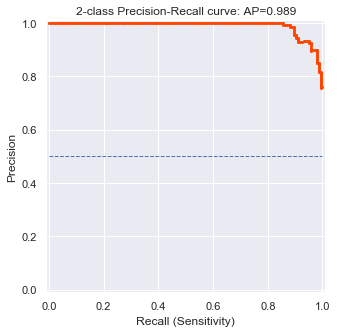

In [53]:
print('Accuracy: %s' % scores_pipe.mean())
print()
print(classification_report(pipe.predict(X_test_cut), y_test))
precission_recall_plot(pipe, X_test_cut)

In [54]:
# Grid Search
# from mlxtend.feature_selection import SequentialFeatureSelector
# selector = SequentialFeatureSelector(LogisticRegression(), scoring='neg_log_loss', verbose=2, k_features=3, forward=False, n_jobs=-1)
# selector.fit(x_data_scaled, y_data)

#### Variance Threshold

In [55]:
from sklearn.feature_selection import VarianceThreshold

In [56]:
var = VarianceThreshold(threshold=0.1)
var.fit(data_adult_cut)
data_adult_var = var.transform(data_adult_cut)

In [57]:
# Number of features decreased
data_adult_cut.shape, data_adult_var.shape

((5255, 145), (5255, 79))

In [58]:
X_train_var = data_adult_var[:cutoff]
X_test_var = data_adult_var[cutoff:]

In [59]:
X_train_cut.shape, X_train_var.shape

((3120, 145), (3120, 79))

In [60]:
start_time = time.clock()

param_grid_vt = {'penalty':['l1','l2'],
                 'C':uniform(0.25,10.0-0.25)}
grid_vt = RandomizedSearchCV(n_iter=30, 
                             estimator=lr, 
                             cv=StratifiedKFold(10, shuffle=True), 
                             param_distributions=param_grid_vt,
                             scoring='balanced_accuracy',
                             n_jobs=-1)
print(grid_vt.fit(X_train_var, y_train))

print('-'*50)
print('Computed in: {} minutes'.format((time.clock()-start_time)/60))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F1DE993C8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)
--------------------------------------------------
Computed in: 4.374239313132591 minutes


In [61]:
grid_vt.best_params_

{'C': 1.672551901365167, 'penalty': 'l1'}

In [62]:
grid_vt.best_estimator_

LogisticRegression(C=1.672551901365167, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 0.9911106224772858

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1947
           1       0.99      0.77      0.86       188

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.99      0.88      0.93      2135
weighted avg       0.98      0.98      0.98      2135

Scores: f1=0.865 auc=0.976 ap=0.976


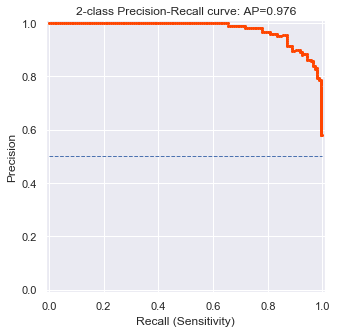

In [63]:
print('Accuracy: %s' % grid_vt.best_score_)
print()
print(classification_report(grid_vt.best_estimator_.predict(X_test_var), y_test))
precission_recall_plot(grid_vt.best_estimator_, X_test_var)

#### RFE

In [64]:
from sklearn.feature_selection import RFE, RFECV

In [65]:
start_time = time.clock()

rfe_estimator = grid_lr.best_estimator_
rfe_selector = RFE(rfe_estimator, step=0.5)

# Takes very long time to compute RFECV with StratifiedKfold
# rfe_selector = RFECV(rfe_estimator, step=5, cv=StratifiedKFold(5, shuffle=True), n_jobs=-1)

print(rfe_selector.fit(data_adult_cut, y))

print('-'*50)
print('Computed in: {} minutes'.format((time.clock()-start_time)/60))

RFE(estimator=LogisticRegression(C=3.4904578463310583, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=None, step=0.5, verbose=0)
--------------------------------------------------
Computed in: 0.8668098119070843 minutes


In [66]:
data_adult_cut.columns[rfe_selector.get_support()]

Index(['nation_Belarus', 'nation_Belgium', 'nation_Ecuador', 'nation_France',
       'nation_Germany', 'nation_Italy', 'nation_New Zealand', 'nation_Norway',
       'nation_Poland', 'nation_Portugal', 'nation_Russia', 'nation_Rwanda',
       'nation_Slovakia', 'nation_Slovenia', 'nation_South Africa',
       'nation_Spain', 'nation_USA', 'finish_Bukowina Tatrzańska',
       'finish_Katowice', 'finish_Warszawa', 'finish_Zabrze',
       'finish_Zakopane', 'wind_dir_N', 'wind_dir_W', 'wind_dir_WSW', 'age',
       'year', 'stage', 'position', 'gc', 'mount_jerseys', 'point_jerseys',
       'sprint_jerseys', 'youth_jerseys', 'followers', 'total_wins', 'n_tours',
       'n_stages', 'avg_pos_ovr', 'avg_time_ovr', 'best_gc_ovr',
       'worst_gc_ovr', 'avg_gc_time_ovr', 'n_top10_ovr', 'n_win_ovr',
       'best_gc_ovr_l3', 'best_gc_time_ovr_l3', 'avg_gc_time_ovr_l3',
       'n_top10_l3', 'n_win_l3', 'perc_top10_ovr', 'perc_win_ovr',
       '2015_fc_rank', '2016_div', '2016_fc_rank', '2016_race_d

In [67]:
support_columns = data_adult_cut.columns[rfe_selector.get_support()]
data_adult_rfe = data_adult_cut[support_columns]

In [68]:
X_train_rfe = data_adult_rfe.iloc[:cutoff,:]
X_test_rfe = data_adult_rfe.iloc[cutoff:,:]

In [69]:
X_train_rfe.shape

(3120, 72)

In [70]:
start_time = time.clock()

param_grid_rfe = {'penalty':['l1','l2'],
                  'C':uniform(0.25,10.0-0.25)}

grid_rfe = RandomizedSearchCV(n_iter=30, 
                              estimator=lr, 
                              cv=StratifiedKFold(10, shuffle=True), 
                              param_distributions=param_grid_rfe,
                              scoring='balanced_accuracy',
                              n_jobs=-1)
print(grid_rfe.fit(X_train_rfe, y_train))

print('-'*50)
print('Computed in: {} minutes'.format((time.clock()-start_time)/60))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024F1F814AC8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='balanced_accuracy',
          verbose=0)
--------------------------------------------------
Computed in: 4.740196769833805 minutes


In [71]:
grid_rfe.best_params_

{'C': 2.6211234049462444, 'penalty': 'l1'}

In [72]:
grid_rfe.best_estimator_

LogisticRegression(C=2.6211234049462444, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy: 0.9928220652600007

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1956
           1       0.98      0.79      0.88       179

   micro avg       0.98      0.98      0.98      2135
   macro avg       0.98      0.90      0.93      2135
weighted avg       0.98      0.98      0.98      2135

Scores: f1=0.877 auc=0.980 ap=0.980


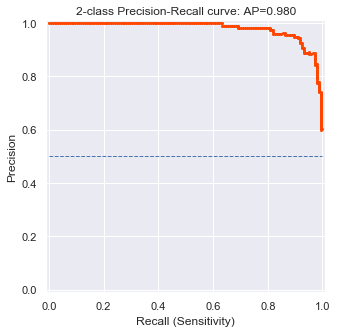

In [73]:
print('Accuracy: %s' % grid_rfe.best_score_)
print()
print(classification_report(grid_rfe.best_estimator_.predict(X_test_rfe), y_test))
precission_recall_plot(grid_rfe.best_estimator_, X_test_rfe)

---------------

**Previous notebooks:** <br>
[Part 1: Data mining and munging](tdp_1_3_data_mining_and_cleaning.ipynb)<br>
[Part 2: Data stats and visuals](tdp_2_3_data_statistics_visualization.ipynb)